# Car Price Prediction Pipeline — Expanded and Detailed Version

This notebook performs all the main steps of a machine learning project:

1. **Loading and initial inspection of the data**  
2. **Cleaning and handling of missing or inconsistent values**  
3. **Feature engineering**  
4. **Exploratory Data Analysis (EDA)**  
5. **Outlier treatment**  
6. **Final data preparation**  
7. **Building the machine learning pipeline**  
8. **Training and saving the model**  
9. **Inference with a new example**


In [5]:
# Essential libraries
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn core tools 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer
)
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV
)
from sklearn.ensemble import (
    RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
)
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

# Other utilities 
from scipy.stats import uniform, randint
import joblib

# Custom feature engineering
from feature_engineer import FeatureEngineer, add_features

# Load and prepare dataset
file_path = 'new_vehicle_all_price.csv'
df = pd.read_csv(file_path)

# Filter out extreme price values
df = df[df['price'].between(2000, 150000)]

# Sample 1000 rows for faster development and consistent results
df = df.sample(n=20000, random_state=42).reset_index(drop=True)

# Show shape and preview
print(f"Shape: {df.shape}")
df.head()


python(11588) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Shape: (20000, 10)


,id,price,fuel,year,manufacturer,model,condition,odometer,transmission,paint_color
0,7312389600,5500,gas,1994,chevrolet,suburban 1500,NaN,117426,automatic,NaN
1,7309218331,29900,gas,2014,ford,f-150,excellent,114000,automatic,white
2,7315434677,3900,gas,2004,pontiac,grand am,NaN,149757,automatic,grey
3,7303628106,31800,gas,1996,ford,f-250 xlt 4x4,excellent,25850,automatic,NaN
4,7306950445,2900,gas,2007,ford,taurus,good,226274,automatic,blue


In [7]:
# Renaming columns to standardize names used in the pipeline
rename_dict = {
    'manufacturer': 'make',         # Standardizing manufacturer name
    'fuel': 'fuel_type',            # Renaming to match feature name
    'odometer': 'Kilometer',        # Making odometer unit explicit
    'year': 'year',                 # No change but kept for consistency
    'price': 'Price'                # Capitalized for emphasis later
}
df.rename(columns=rename_dict, inplace=True)
df.head(5)




,id,Price,fuel_type,year,make,model,condition,Kilometer,transmission,paint_color
0,7312389600,5500,gas,1994,chevrolet,suburban 1500,NaN,117426,automatic,NaN
1,7309218331,29900,gas,2014,ford,f-150,excellent,114000,automatic,white
2,7315434677,3900,gas,2004,pontiac,grand am,NaN,149757,automatic,grey
3,7303628106,31800,gas,1996,ford,f-250 xlt 4x4,excellent,25850,automatic,NaN
4,7306950445,2900,gas,2007,ford,taurus,good,226274,automatic,blue


In [9]:
# Filling categorical columns with the most frequent value (mode)
for col in ['condition', 'transmission', 'paint_color']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

# Exibir os valores ausentes após o tratamento
print("\nMissing values after treatment:")
print(df.isnull().sum())



Missing values after treatment:
id                0
Price             0
fuel_type       128
year              0
make              0
model             0
condition         0
Kilometer         0
transmission      0
paint_color       0
dtype: int64



Distributions of numerical variables:


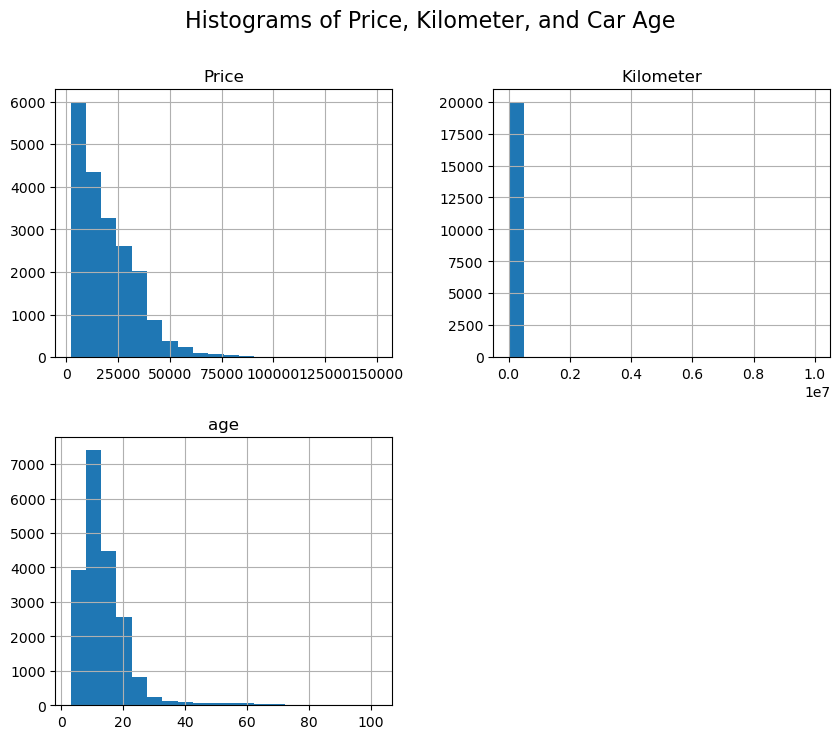

In [11]:
# ## 5) Visualization of numerical variable distributions

# Print label for context
print("\nDistributions of numerical variables:")

# Create a new feature: car age (current year minus year of manufacture)
df['age'] = datetime.datetime.now().year - df['year']

# Plot histograms for price, mileage, and age
# This helps understand data spread and detect skewness or outliers
df[['Price', 'Kilometer', 'age']].hist(
    bins=20,            # Number of histogram bins
    figsize=(10, 8)     # Size of the overall plot area
)
plt.suptitle("Histograms of Price, Kilometer, and Car Age", fontsize=16)
plt.show()


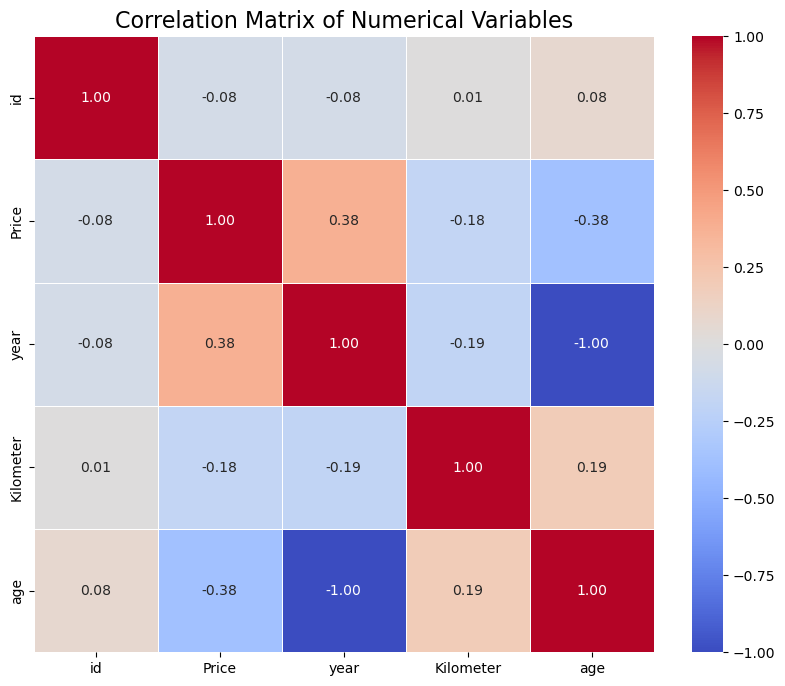

In [13]:
# ## 6) Correlation analysis between numerical variables

# Select all numeric columns from the dataset
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix to see linear relationships
correlation_matrix = df[numerical_columns].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,         # Show correlation coefficients inside the heatmap
    cmap='coolwarm',    # Color scale from blue (negative) to red (positive)
    fmt=".2f",          # Format correlation values with 2 decimal places
    linewidths=0.5      # Thin lines between cells for readability
)
plt.title("Correlation Matrix of Numerical Variables", fontsize=16)
plt.show()


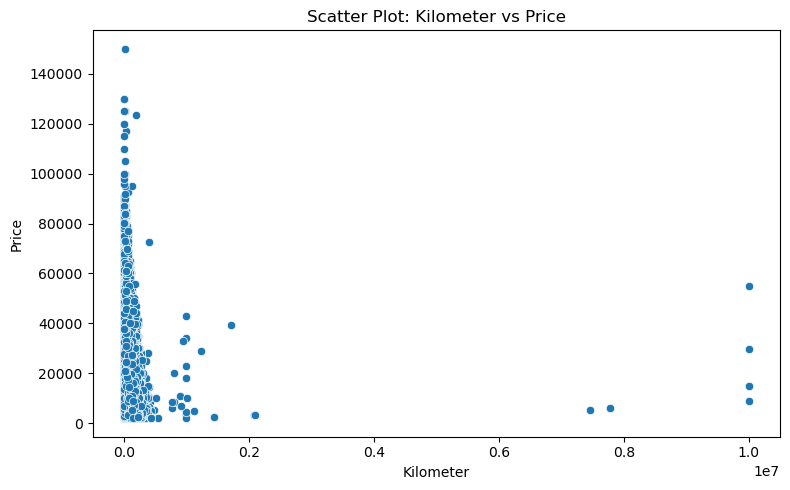

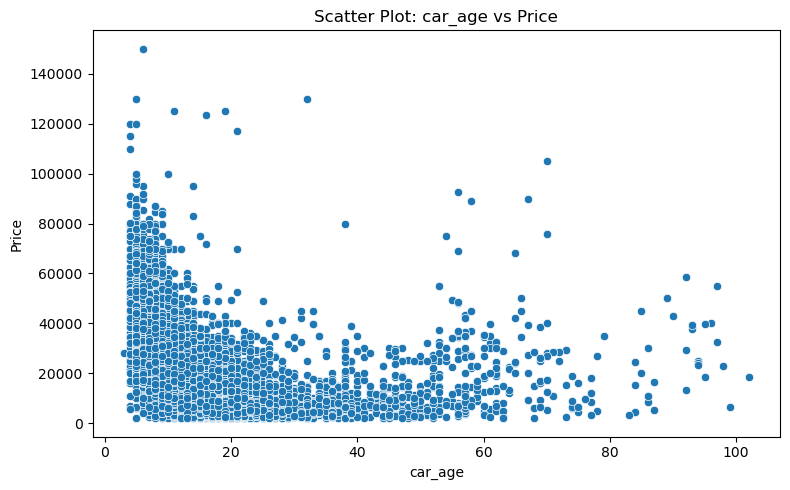

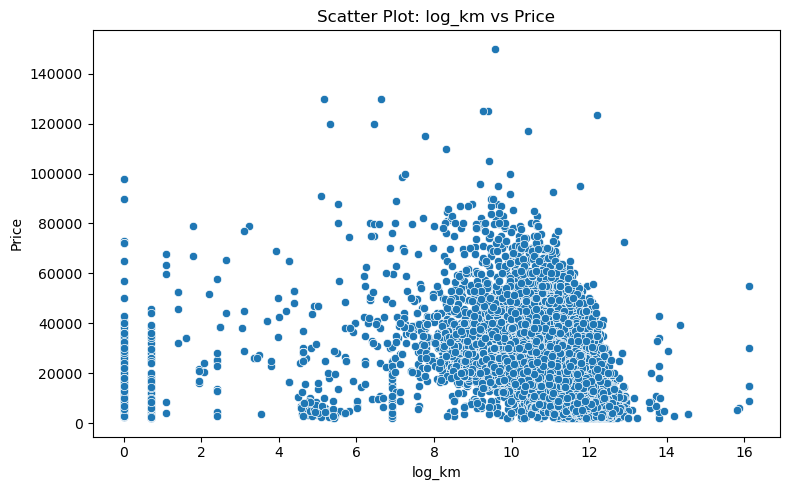

In [15]:
# ## 6.1) Scatter plots to visualize relationships between numerical variables and price

# Create derived features for better analysis
df['car_age'] = datetime.datetime.now().year - df['year']        # Age of the car
df['log_km'] = np.log1p(df['Kilometer'])                         # Log-transformed mileage
df['price_log'] = np.log1p(df['Price'])                          # Log-transformed price

# List of features to compare against Price
features_to_plot = ['Kilometer', 'car_age', 'log_km']

# Generate scatter plots to observe trends or patterns between features and price
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df[feature], y=df['Price'])
    plt.title(f"Scatter Plot: {feature} vs Price")               # Chart title
    plt.xlabel(feature)                                          # X-axis label
    plt.ylabel('Price')                                          # Y-axis label
    plt.tight_layout()
    plt.show()


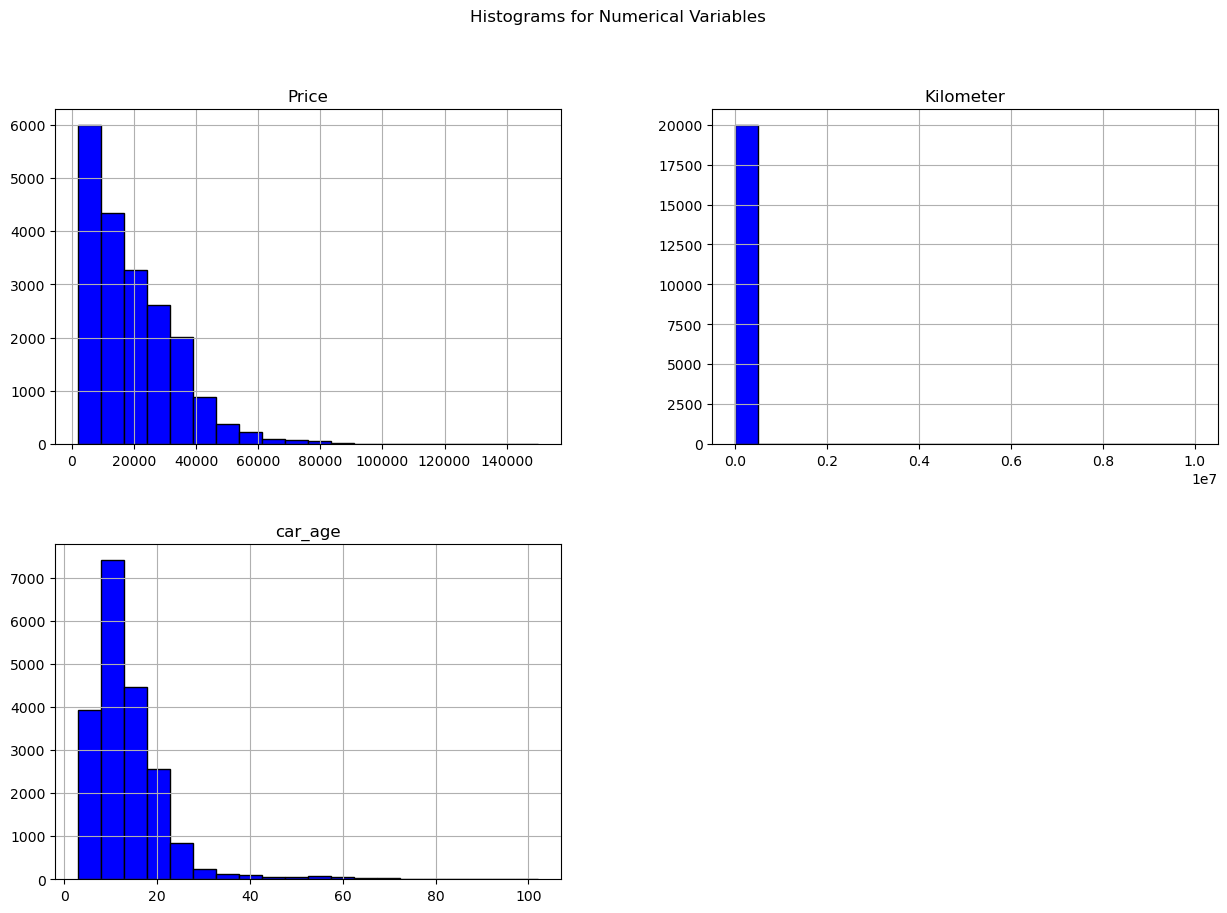

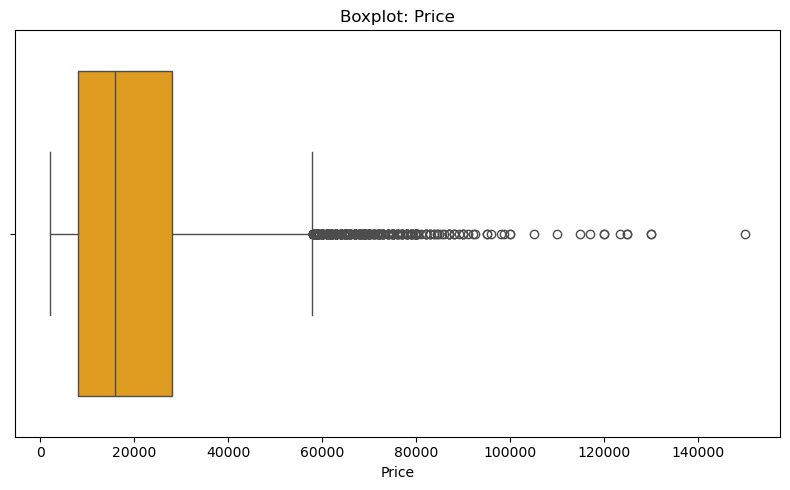

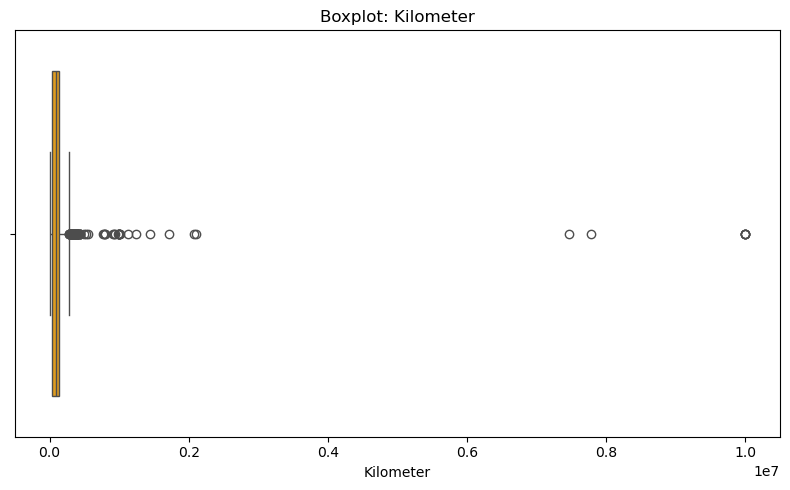

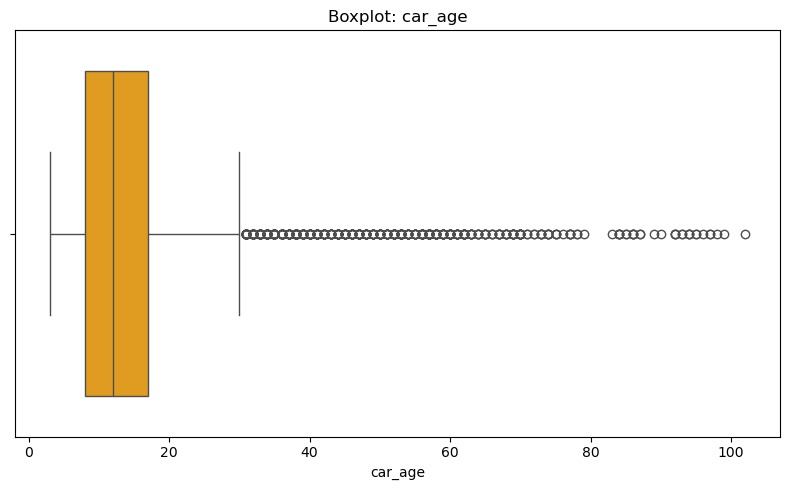

In [17]:
# ## 6.2) Histograms and boxplots for numerical variables

# Generate car age if not already in the DataFrame
if 'car_age' not in df.columns:
    df['car_age'] = datetime.datetime.now().year - df['year']

# Define a list of numerical features to visualize
numerical_features = ['Price', 'Kilometer', 'car_age']
if 'Engine' in df.columns:
    numerical_features.append('Engine')
if 'Max Power' in df.columns:
    numerical_features.append('Max Power')

# Plot histograms for each numerical feature
df[numerical_features].hist(
    bins=20, figsize=(15, 10), color='blue', edgecolor='black'
)
plt.suptitle("Histograms for Numerical Variables")
plt.show()

# Plot boxplots to detect outliers in each numerical feature
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[feature], color='orange')
    plt.title(f"Boxplot: {feature}")
    plt.tight_layout()
    plt.show()


In [19]:
# ## 7) Removing records with missing values in essential columns

# Define the list of essential columns required for modeling
col_required = ['make', 'model', 'fuel_type', 'transmission', 'Kilometer', 'year', 'Price']

# Drop any rows where at least one of the essential columns is missing
df.dropna(subset=col_required, inplace=True)


In [21]:
# ## 8) Data type conversion and removal of extreme outliers

# Convert key columns to numeric types, coercing errors to NaN
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Kilometer'] = pd.to_numeric(df['Kilometer'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Remove entries with unrealistically low prices (e.g., below 1000)
df = df[df['Price'] >= 1000]


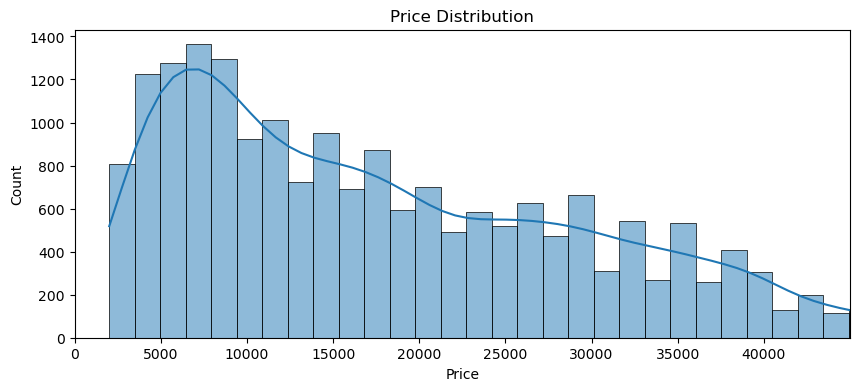

In [23]:
# ## 9) Visualization of price distribution (updated)

# Create a histogram of the Price column with a KDE curve
plt.figure(figsize=(10, 4))
sns.histplot(df['Price'], bins=100, kde=True)

# Set chart title and limit x-axis to the 95th percentile to reduce skew from outliers
plt.title("Price Distribution")
plt.xlim(0, df['Price'].quantile(0.95))

# Display the plot
plt.show()


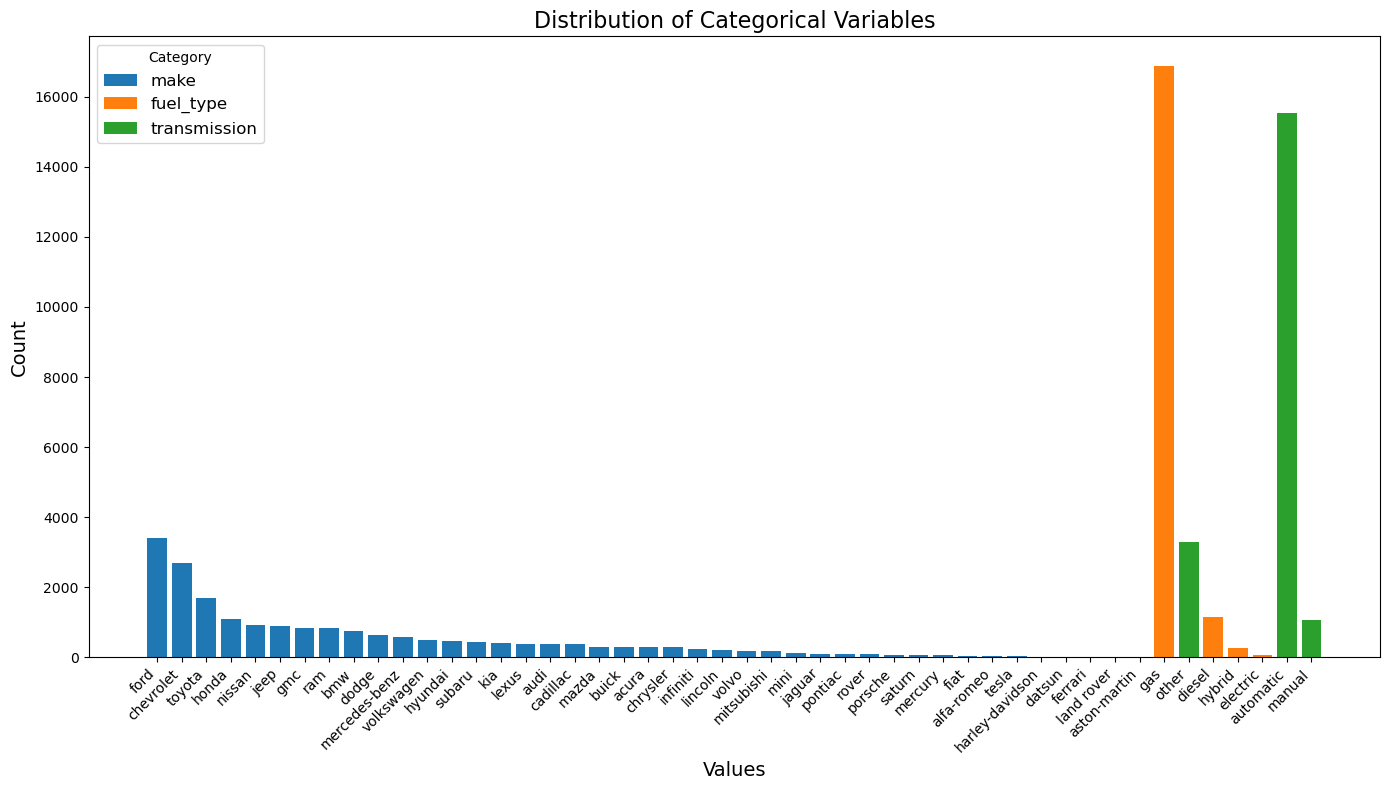

In [25]:
# ## 10) Visualization of categorical variable distributions

# Count occurrences for selected categorical features
categories = {
    'make': df['make'].value_counts(),
    'fuel_type': df['fuel_type'].value_counts(),
    'transmission': df['transmission'].value_counts()
}

# Combine all counts into a single DataFrame for plotting
combined_df = pd.concat(categories).reset_index()
combined_df.columns = ['Category', 'Value', 'Count']

# Plot a grouped bar chart showing distribution for each categorical variable
plt.figure(figsize=(14, 8))
for category in combined_df['Category'].unique():
    cat_data = combined_df[combined_df['Category'] == category]
    plt.bar(cat_data['Value'], cat_data['Count'], label=category)

# Customize plot appearance
plt.title("Distribution of Categorical Variables", fontsize=16)
plt.xlabel("Values", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend(title="Category", fontsize=12)
plt.tight_layout()
plt.show()


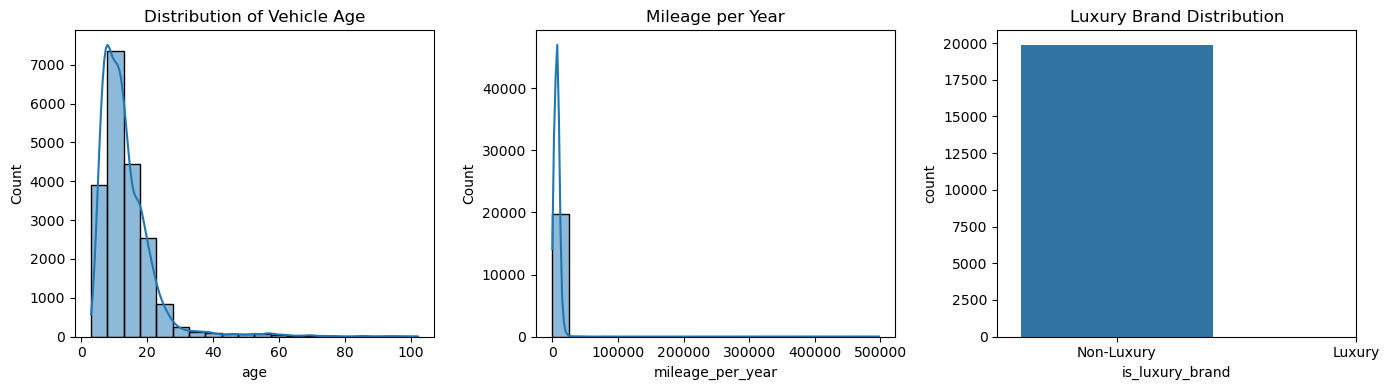

In [37]:
# Feature Transformation 
# Apply custom feature engineering (e.g., calculate car age, mileage per year, luxury flag)
feature_transform = FunctionTransformer(add_features)


# Sampling and Feature-Target Split
# Randomly sample 20.000 rows for training (to reduce training time during prototyping)
sample_df = df.sample(n=min(20000, len(df)), random_state=42)

# Select relevant features and target variable
X = sample_df[['make', 'model', 'fuel_type', 'transmission', 'Kilometer', 'year']]
y = np.log1p(sample_df['Price'])  # Apply log transformation to reduce skewness

# Apply the custom transformation to enrich feature set
X = feature_transform.transform(X)


# Visual inspection of engineered features
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.histplot(X['age'], bins=20, kde=True)
plt.title("Distribution of Vehicle Age")

plt.subplot(1, 3, 2)
sns.histplot(X['mileage_per_year'], bins=20, kde=True)
plt.title("Mileage per Year")

plt.subplot(1, 3, 3)
sns.countplot(x='is_luxury_brand', data=X)
plt.title("Luxury Brand Distribution")
plt.xticks([0, 1], ['Non-Luxury', 'Luxury'])

plt.tight_layout()
plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits


python(14876) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14877) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14878) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14879) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14880) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14881) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14882) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(14883) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Fitting 3 folds for each of 10 candidates, totalling 30 fits


python(15733) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(15734) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16354) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16355) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16356) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16357) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16358) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Random Forest Best Params: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 9, 'model__n_estimators': 443}
HistGradientBoosting Best Params: {'model__learning_rate': 0.08116262258099886, 'model__max_depth': 8, 'model__max_iter': 420}
Test RMSE: 0.38
Test R²: 0.765


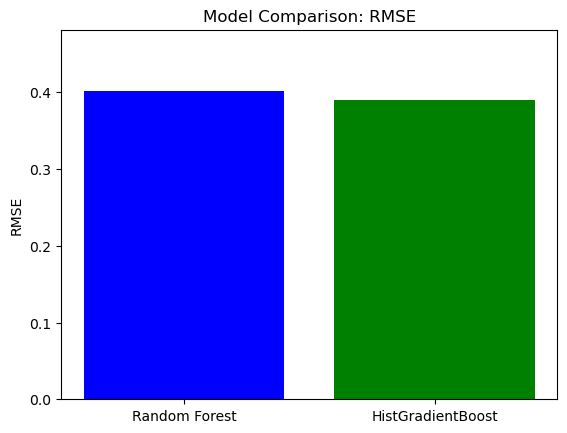

In [41]:

# Train-Test Split 
# Split data into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Preprocessing Pipeline 
# Define preprocessing: scale numerical features, one-hot encode categorical ones
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

cat_feats = ['make', 'model', 'fuel_type', 'transmission']              # Categorical features
num_feats = ['age', 'mileage_per_year', 'is_luxury_brand']              # Engineered numerical features

# Combine all preprocessing steps into a unified transformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),                               # Normalize numerical data
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats)  # Encode categories
], sparse_threshold=0.3)

# Base Model Pipelines
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# Random Forest pipeline
rf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Histogram-based Gradient Boosting pipeline
gb = Pipeline([
    ('prep', preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=42))
])

# Hyperparameter Tuning 
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter space for Random Forest
rf_params = {
    'model__n_estimators': randint(150, 500),
    'model__max_depth': [None] + list(range(10, 25, 5)),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5)
}

# Define hyperparameter space for Gradient Boosting
gb_params = {
    'model__learning_rate': uniform(0.01, 0.19),
    'model__max_iter': randint(150, 600),
    'model__max_depth': randint(4, 10)
}

# Perform randomized search with 3-fold CV for Random Forest
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=3,
                               scoring='neg_root_mean_squared_error',
                               random_state=42, n_jobs=-1, verbose=1)
rf_search.fit(X_train, y_train)

# Same for Gradient Boosting
gb_search = RandomizedSearchCV(gb, gb_params, n_iter=10, cv=3,
                               scoring='neg_root_mean_squared_error',
                               random_state=42, n_jobs=-1, verbose=1)
gb_search.fit(X_train, y_train)

# Retrieve best models from each search
best_rf = rf_search.best_estimator_
best_gb = gb_search.best_estimator_

# Final Gradient Boosting Pipeline
# Rebuild GB pipeline with best parameters (to ensure it's serializable without nested objects)
gb_no_densify = Pipeline([
    ('prep', preprocessor),
    ('model', HistGradientBoostingRegressor(**best_gb.named_steps['model'].get_params()))
])

# Model Stacking 
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

# Combine best RF and GB models into a stacked ensemble with RidgeCV as the meta-model
stack = StackingRegressor(
    estimators=[('rf', best_rf), ('hgb', gb_no_densify)],
    final_estimator=RidgeCV(),
    n_jobs=-1
)

# Train the final stacked model
stack.fit(X_train, y_train)

# === Model Evaluation ===
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
test_preds = stack.predict(X_test)

# Compute RMSE and R² for performance assessment
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
r2_test = r2_score(y_test, test_preds)

# Display best hyperparameters and evaluation metrics
print("Random Forest Best Params:", rf_search.best_params_)
print("HistGradientBoosting Best Params:", gb_search.best_params_)
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test R²: {r2_test:.3f}")

# Predict using best estimators before stacking
rf_preds = best_rf.predict(X_test)
gb_preds = best_gb.predict(X_test)

# Calculate RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_preds))
rmse_gb = np.sqrt(mean_squared_error(y_test, gb_preds))

# Plot
models = ['Random Forest', 'HistGradientBoost']
rmse_scores = [rmse_rf, rmse_gb]
plt.bar(models, rmse_scores, color=['blue', 'green'])
plt.ylabel("RMSE")
plt.title("Model Comparison: RMSE")
plt.ylim(0, max(rmse_scores)*1.2)
plt.show()

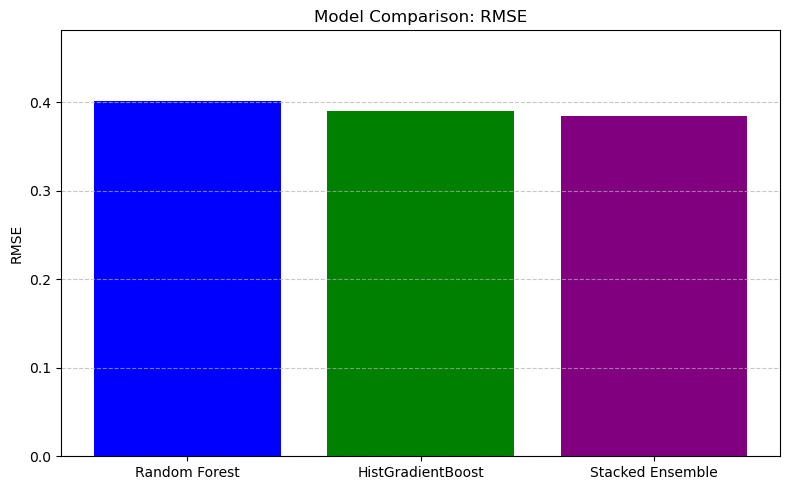


Model RMSEs:
Random Forest RMSE: 0.401
Gradient Boosting RMSE: 0.390
Stacked Ensemble RMSE: 0.385


In [46]:
# Calculate RMSE for stacked model
rmse_stack = np.sqrt(mean_squared_error(y_test, test_preds))

# Add Stacked model to comparison plot
models = ['Random Forest', 'HistGradientBoost', 'Stacked Ensemble']
rmse_scores = [rmse_rf, rmse_gb, rmse_stack]

# Plotting all models
plt.figure(figsize=(8, 5))
plt.bar(models, rmse_scores, color=['blue', 'green', 'purple'])
plt.ylabel("RMSE")
plt.title("Model Comparison: RMSE")
plt.ylim(0, max(rmse_scores)*1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optionally, print scores for the report
print(f"\nModel RMSEs:")
print(f"Random Forest RMSE: {rmse_rf:.3f}")
print(f"Gradient Boosting RMSE: {rmse_gb:.3f}")
print(f"Stacked Ensemble RMSE: {rmse_stack:.3f}")


In [66]:
import joblib

# Final Pipeline Creation and Saving 

# Combine feature engineering and the trained stacking model into a single pipeline
final_pipeline = Pipeline([
    ('feat_eng', feature_transform),  # Step 1: Apply custom feature transformations
    ('model', stack)                  # Step 2: Use the stacked ensemble model for prediction
])

# Save the complete pipeline to a .pkl file for future inference
joblib.dump(final_pipeline, 'car_price_stacked_pipeline.pkl', protocol=4)

print("Stacked model saved successfully!")


Stacked model saved successfully!


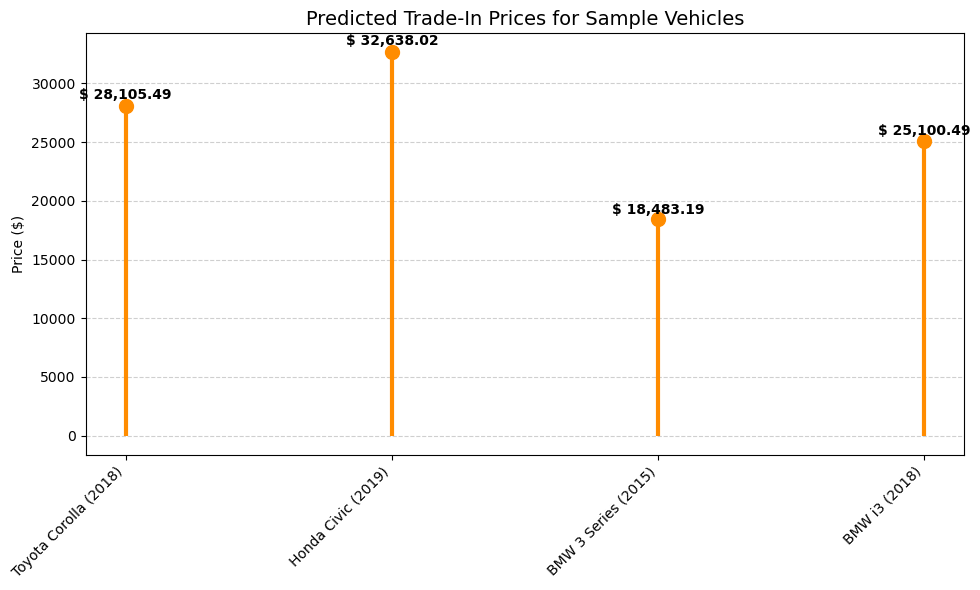

In [64]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the trained model
model = joblib.load('car_price_stacked_pipeline.pkl')

# Sample vehicles
vehicles = [
    {'make': 'Toyota', 'model': 'Corolla', 'fuel_type': 'petrol', 'transmission': 'automatic', 'year': 2018, 'Kilometer': 55000},
    {'make': 'Honda', 'model': 'Civic', 'fuel_type': 'petrol', 'transmission': 'automatic', 'year': 2019, 'Kilometer': 30000},
    {'make': 'BMW', 'model': '3 Series', 'fuel_type': 'petrol', 'transmission': 'automatic', 'year': 2015, 'Kilometer': 90000},
    {'make': 'BMW', 'model': 'i3', 'fuel_type': 'electric', 'transmission': 'automatic', 'year': 2018, 'Kilometer': 20000}
]

# Create DataFrame
df_samples = pd.DataFrame(vehicles)

# Predict prices
log_preds = model.predict(df_samples)
price_preds = np.expm1(log_preds)

# Add predicted prices
df_samples['Predicted Price ($)'] = price_preds
df_samples['Label'] = df_samples['make'] + ' ' + df_samples['model'] + ' (' + df_samples['year'].astype(str) + ')'

# Lollipop Plot
plt.figure(figsize=(10, 6))
for i, row in df_samples.iterrows():
    plt.plot([row['Label']], [row['Predicted Price ($)']], 'o', markersize=10, color='darkorange')
    plt.vlines(x=row['Label'], ymin=0, ymax=row['Predicted Price ($)'], color='darkorange', linewidth=3)
    plt.text(row['Label'], row['Predicted Price ($)'] * 1.02, f"$ {row['Predicted Price ($)']:,.2f}",
             ha='center', fontsize=10, fontweight='bold')

plt.title('Predicted Trade-In Prices for Sample Vehicles', fontsize=14)
plt.ylabel('Price ($)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Top 10 features:
 age                 0.586470
mileage_per_year    0.156071
fuel_type_diesel    0.053434
make_nissan         0.008319
fuel_type_gas       0.008129
make_chevrolet      0.008069
make_volkswagen     0.007776
make_gmc            0.007170
make_ford           0.006605
make_kia            0.006046
dtype: float64


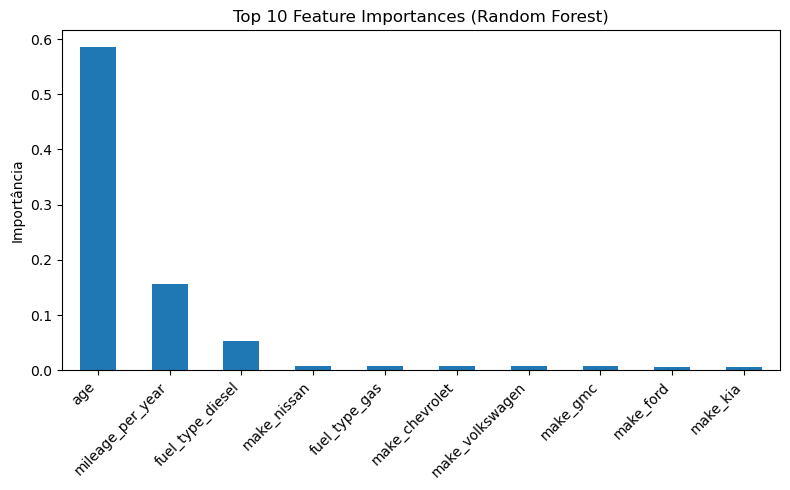

In [52]:
# Extrai nomes das features transformadas do best_rf
preproc = best_rf.named_steps['prep']
cat_names = list(preproc.named_transformers_['cat'].get_feature_names_out(cat_feats))
feature_names = num_feats + cat_names

# Importância das features no Random Forest
importances = best_rf.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Exibe top 10
print("Top 10 features:\n", feat_imp.head(10))

# Plot
plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importância')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [62]:
import os
os.path.getsize("car_price_stacked_pipeline.pkl")

305949906

In [77]:
!pip install gdown
import gdown
gdown.download("https://drive.google.com/uc?id=1cpMyNSxLTBVixk-2BrjBlZP8nDd6-6YH", "model_test.pkl", quiet=False)


python(37789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Downloading...
From (original): https://drive.google.com/uc?id=1cpMyNSxLTBVixk-2BrjBlZP8nDd6-6YH
From (redirected): https://drive.google.com/uc?id=1cpMyNSxLTBVixk-2BrjBlZP8nDd6-6YH&confirm=t&uuid=f1fbb720-1b34-4e0e-8fa4-237d19b6bd7a
To: /Users/yuribraga/Documents/strategic-thinking/strategic-thinking-ca-1/model_test.pkl
100%|██████████| 306M/306M [00:22<00:00, 13.4MB/s] 


'model_test.pkl'